In this notebook we will create the Probabilistic analysis (probability distribution and heatmap) for each of the agent's mode and traffic profiles per slice.

In [1]:
import sys
sys.path.insert(0, '../')

# # Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ast
import os
from graphviz import Digraph
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import seaborn as sns

# Import Constatns
from script.experiments_constants import AGENT_EXPERIMENT_INFO
from script.experiments_constants import ENV_KPI_NAME_LIST

# Import graph creator function from utils
from script.utils import plot_graph_from_data


from constants import proj_address

from script.load_data import handle_data
from script.symbolic_representation import create_symbolic_state_decision_matrix

# Load and Show some results for each one of the agents

In this part we will load the data of one of the agents and visualize some of the numerical data.

## Graph Plotter Function Code

In [2]:
# Choose one of the agents: 'embb-trf1', 'embb-trf2', 'urllc-trf1', 'urllc-trf2'
agent = 'urllc-trf2'

# Choose one of the users: 3, 4, 5, 6 - Combination of agent and user will determine a specific experiment
user = 6

# Assuming AGENT_EXPERIMENT_INFO, handle_data and create_symbolic_state_decision_matrix are defined elsewhere in your codebase
agent_info = AGENT_EXPERIMENT_INFO[agent]
kpi_data, decision_data = handle_data(agent_info, user)
symbolic_df, marker_df = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, user)
symbolic_df['combined_decision'] = symbolic_df.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)

print(f"Agent: {agent} - Users: {user}")
print("")

Agent: urllc-trf2 - Users: 6



## Plot the Probability Distributino of agent's effects on the environment

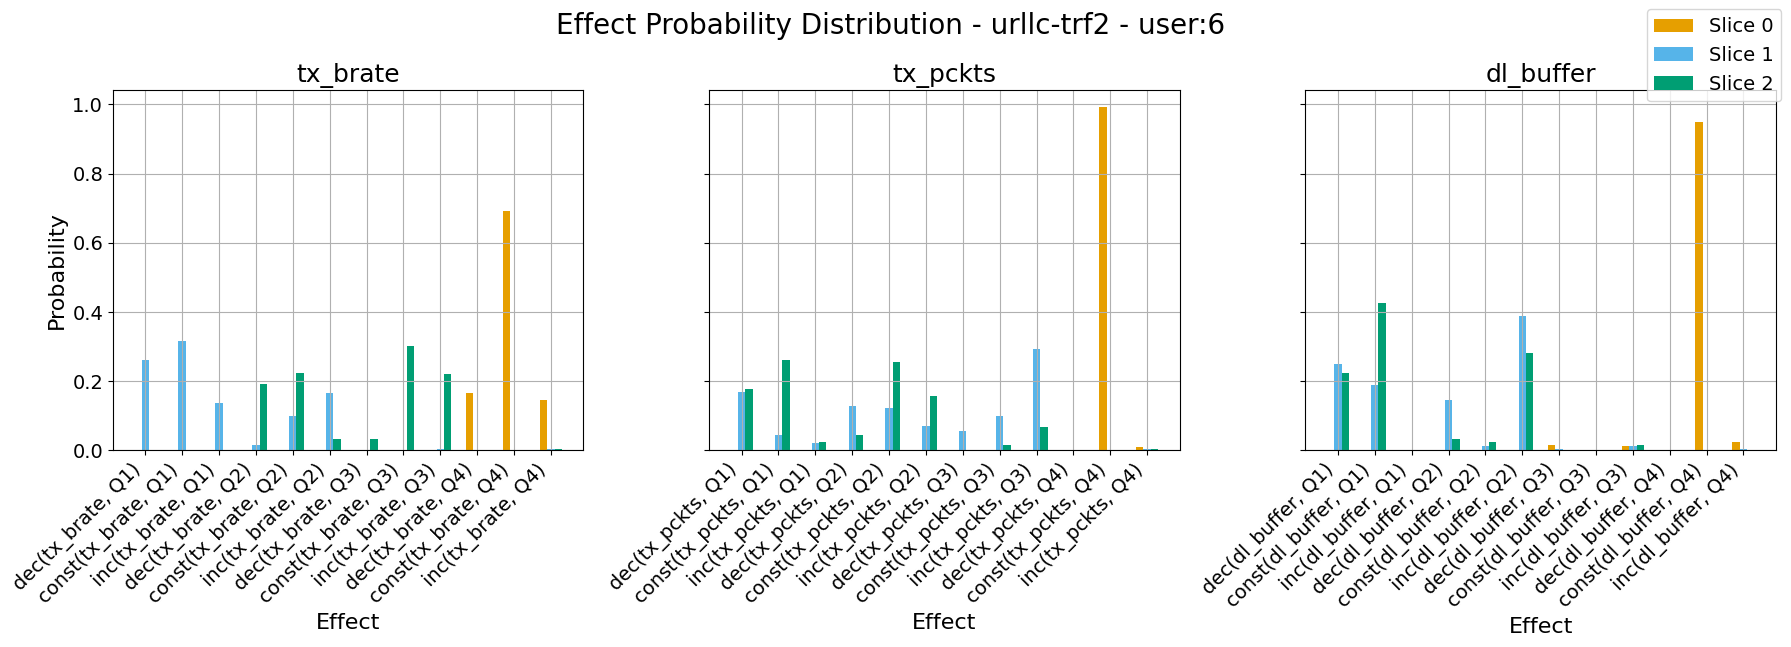

Figure saved as /home/erfan/Projects/symbxrl/A1-NetworkSlicingSchedulingPolicy/results/Probabilistic_Analysis/prob_dist/Effect_Probability_Distribution_urllc-trf2_user_6.pdf


In [7]:
def create_effects_list(kpis=['tx_brate', 'tx_pckts', 'dl_buffer'], changes=['dec', 'const', 'inc']):
    return {
        kpi: [f'{change}({kpi}, Q{quartile})' for quartile in range(1, 5) for change in changes] for kpi in kpis
    }

# Define slices and KPIs
slices = [0, 1, 2]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
effects_list = create_effects_list()

# Color Universal Design (CUD) color scheme for color blind friendliness
colors = ["#E69F00", "#56B4E9", "#009E73"]  # Orange, Sky Blue, Bluish Green

# Create a 1x3 subplot figure
fig, axes = plt.subplots(1, len(kpis), figsize=(18, 6), sharey=True)
fig.suptitle(f'Effect Probability Distribution - {agent} - user:{user}', fontsize=20)

bar_width = 0.2
x = np.arange(len(effects_list[kpis[0]]))

for i, kpi in enumerate(kpis):
    for j, slice_id in enumerate(slices):
        # Filter data for the current slice
        slice_data = symbolic_df[symbolic_df['slice_id'] == slice_id]
        
        # Calculate the effect probability
        effect_counts = slice_data[kpi].value_counts(normalize=True).reindex(effects_list[kpi], fill_value=0)
        
        # Plot the probability distribution as a bar plot
        if i == 0:  # Only add the label once for the legend
            axes[i].bar(x + j * bar_width, effect_counts.values, bar_width, label=f'Slice {slice_id}', color=colors[j])
        else:
            axes[i].bar(x + j * bar_width, effect_counts.values, bar_width, color=colors[j])
    
    # Set titles and labels
    axes[i].set_title(f'{kpi}', fontsize=18)
    axes[i].set_xlabel('Effect', fontsize=16)
    axes[i].set_xticks(x + bar_width)
    axes[i].set_xticklabels(effects_list[kpi], rotation=45, ha='right')
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].grid(True)

# Set a common y-axis label
axes[0].set_ylabel('Probability', fontsize=16)

# Add a legend
fig.legend(loc='upper right', fontsize=14)

# Adjust the subplot layout to make room for the rotated labels
plt.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.25)

# Display the plot
plt.show()

# Save the figure as PDF
output_dir = f'{proj_address}/A1-NetworkSlicingSchedulingPolicy/results/Probabilistic_Analysis/prob_dist'  # Specify the directory to save the graphs
os.makedirs(output_dir, exist_ok=True)
file_name = f'Effect_Probability_Distribution_{agent}_user_{user}.pdf'
pdf_file_path = os.path.join(output_dir, file_name)
fig.savefig(pdf_file_path, format='pdf', bbox_inches='tight')

print(f"Figure saved as {pdf_file_path}")

## Plot the heat map of decision and their effects on the environment

Agent: urllc-trf2 - Users: 6



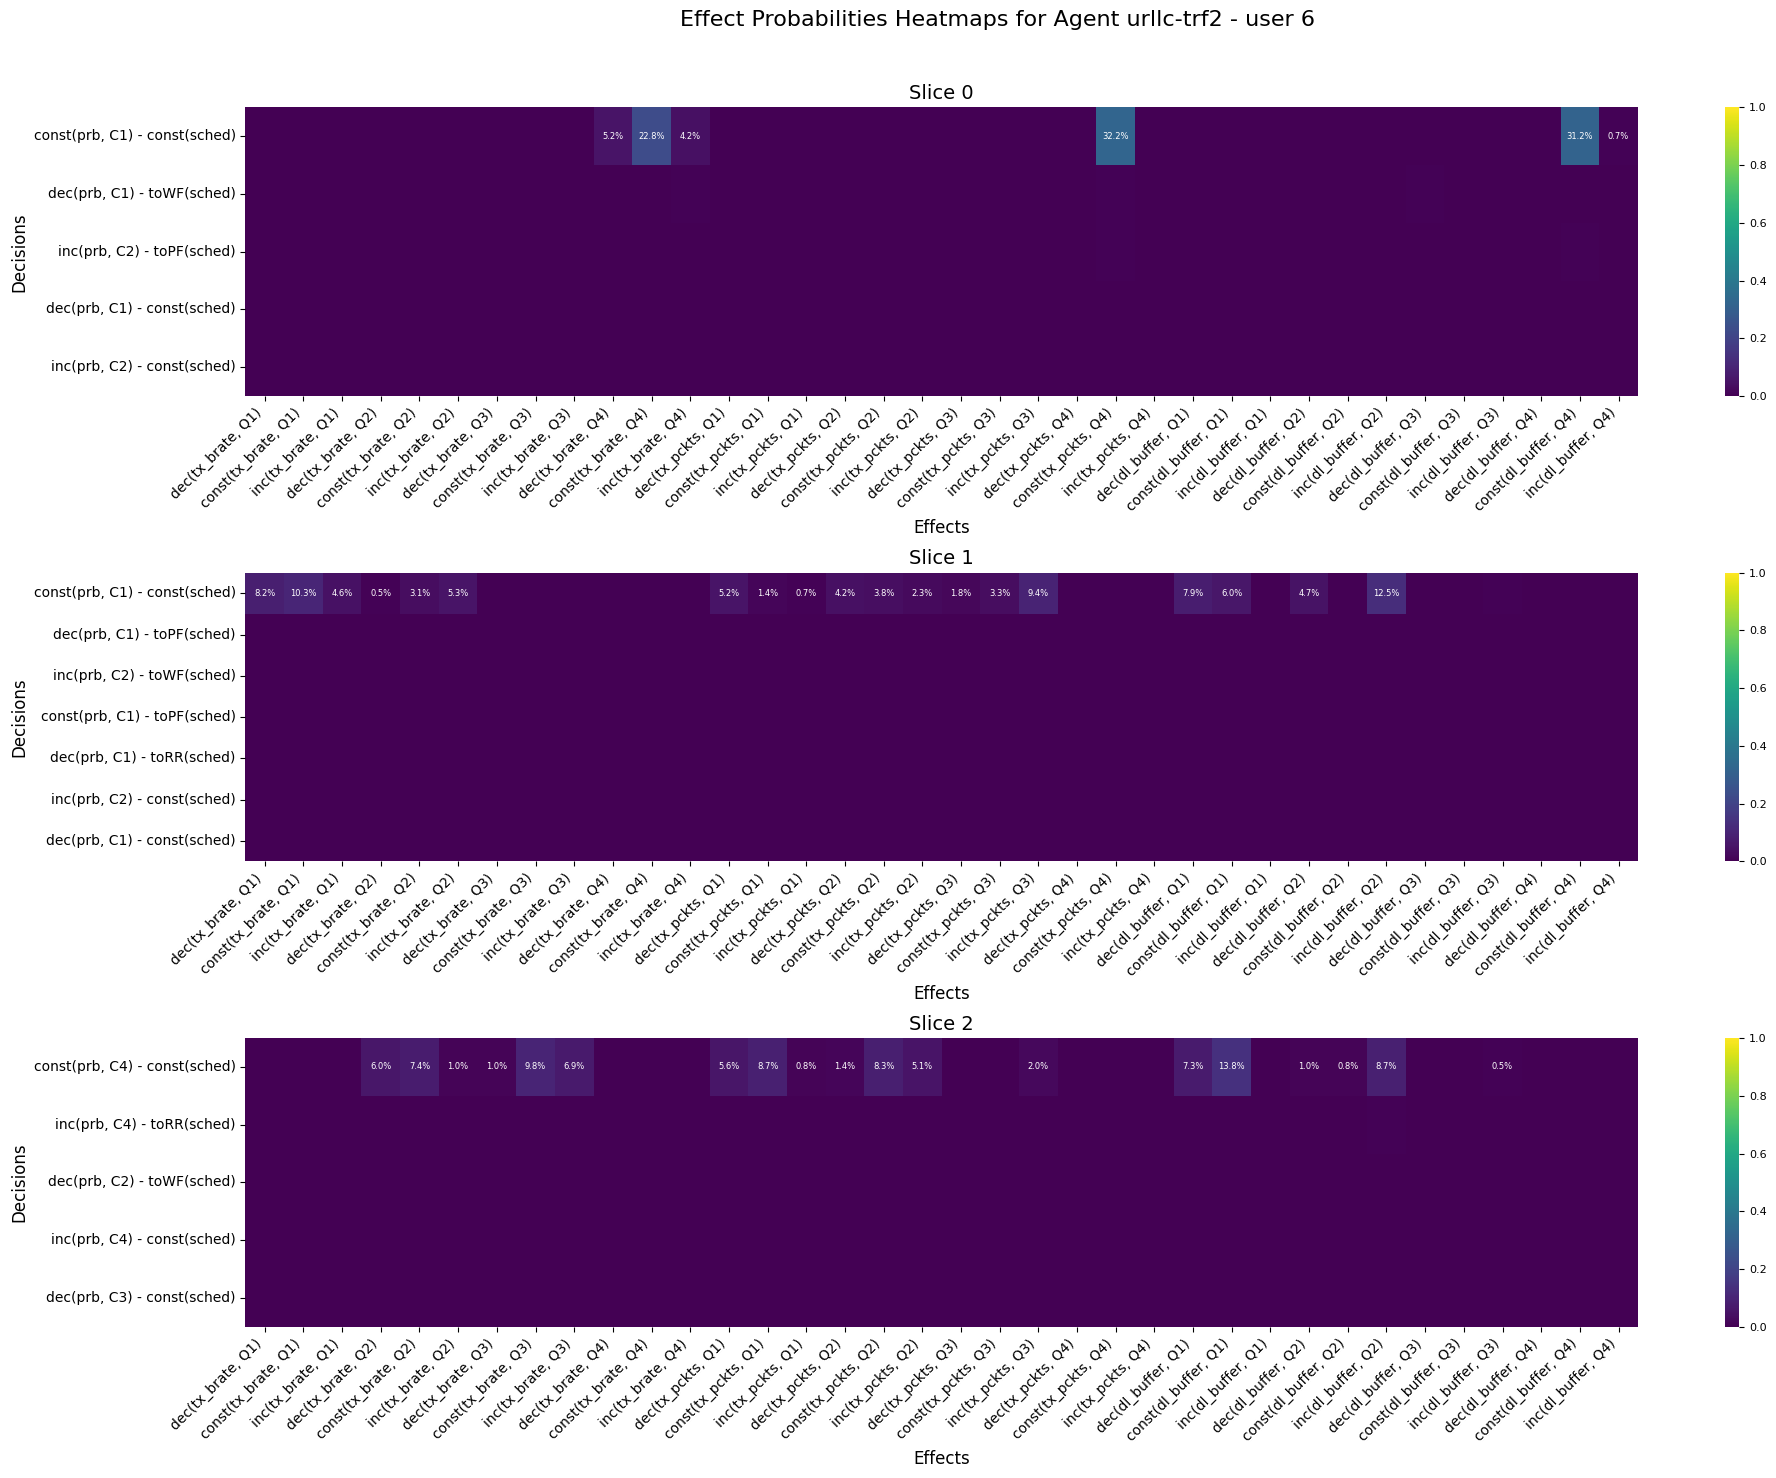

Figure saved as /home/erfan/Projects/symbxrl/A1-NetworkSlicingSchedulingPolicy/results/Probabilistic_Analysis/heatmaps/Effect_Probabilities_Heatmaps_urllc-trf2_user_6.pdf


In [28]:
def create_effects_list(kpis=['tx_brate', 'tx_pckts', 'dl_buffer'], changes=['dec', 'const', 'inc']):
    return {
        kpi: [f'{change}({kpi}, Q{quartile})' for quartile in range(1, 5) for change in changes] for kpi in kpis
    }

effects_list = create_effects_list()
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]

plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

def plot_heatmaps(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    # Concatenate all effects
    all_effects = [effect for kpi in kpis for effect in effects_list[kpi]]

    cmap = 'viridis'

    def format_value(val):
        if val >= 0.005:  # Threshold set to 0.005
            return f'{val * 100:.1f}%'  # Show as percentage with one decimal place
        return ''

    # Create a 3x1 subplot figure
    fig, axes = plt.subplots(len(slices), 1, figsize=(20, 15))
    fig.suptitle(f'Effect Probabilities Heatmaps for Agent {agent} - user {user}', fontsize=16)

    for idx, slice_id in enumerate(slices):
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]

        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Calculate the height based on the number of decisions in this slice
        decision_height = 0.3  # Height per decision in inches
        min_height = 5  # Minimum height of the plot
        calculated_height = max(min_height, len(sorted_slice_decisions) * decision_height)

        # Initialize the matrix for all KPIs and decisions in this slice
        div_matrix = np.zeros((len(sorted_slice_decisions), len(all_effects)))

        for i, decision in enumerate(sorted_slice_decisions):
            decision_data = slice_data[slice_data['combined_decision'] == decision]
            
            if not decision_data.empty:
                col_index = 0
                for kpi in kpis:
                    kpi_effects = effects_list[kpi]
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[i, col_index:col_index+len(kpi_effects)] = effect_counts.values
                    col_index += len(kpi_effects)

        # Normalize the matrix for this slice
        div_matrix = div_matrix / np.sum(div_matrix)

        # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
        total_sum = np.sum(div_matrix)
        if not np.isclose(total_sum, 1.0, atol=1e-6):
            print(f"Warning: Sum for slice {slice_id} is {total_sum}, which is not 1.")

        # Create a custom annotation array
        annot = np.vectorize(format_value)(div_matrix)

        # Plot heatmap with fixed scale from 0 to 1 and display formatted values
        sns.heatmap(div_matrix, ax=axes[idx], cmap=cmap, vmin=0, vmax=1, cbar=True, 
                    annot=annot, fmt='', annot_kws={'size': 6}, linewidths=0, linecolor='white')

        axes[idx].set_title(f'Slice {slice_id}', fontsize=14)
        axes[idx].set_xlabel('Effects', fontsize=12)
        axes[idx].set_ylabel('Decisions', fontsize=12)
        
        # Adjust x-axis ticks with rotated labels
        axes[idx].set_xticks(np.arange(len(all_effects)) + 0.5)
        axes[idx].set_xticklabels(all_effects, rotation=45, ha='right', va='top', fontsize=10)
        
        # Adjust y-axis ticks
        axes[idx].set_yticks(np.arange(len(sorted_slice_decisions)) + 0.5)
        axes[idx].set_yticklabels(sorted_slice_decisions, rotation=0, fontsize=10)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure as PDF
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(output_path, format='pdf', bbox_inches='tight')

    # Display the plot
    plt.show()

# Define the agent and user
agent = 'urllc-trf2'
user = 6

# Assuming AGENT_EXPERIMENT_INFO, handle_data and create_symbolic_state_decision_matrix are defined elsewhere in your codebase
agent_info = AGENT_EXPERIMENT_INFO[agent]
kpi_data, decision_data = handle_data(agent_info, user)
symbolic_df, marker_df = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, user)
symbolic_df['combined_decision'] = symbolic_df.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)

print(f"Agent: {agent} - Users: {user}")
print("")

# Plot the heatmaps for the specified agent and user and save as PDF
output_file = f'{proj_address}/A1-NetworkSlicingSchedulingPolicy/results/Probabilistic_Analysis/heatmaps/Effect_Probabilities_Heatmaps_{agent}_user_{user}.pdf'
plot_heatmaps(symbolic_df, agent, effects_list, kpis, slices, output_file)

print(f"Figure saved as {output_file}")